In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
import datetime
import matplotlib.pyplot as plt

In [2]:
def tune_alpha(x_train,x_validate,y_train,y_validate):
    alp =np.logspace(-2, 5, 1000).tolist()
    column_names = ["alpha", "RMSE","MAE"]
    data =[]
    for i in alp:
        model = Ridge(alpha=i)
        model.fit(x_train, y_train)
        y_validate_predict = model.predict(x_validate)
        rmse=mean_squared_error(y_validate, y_validate_predict, squared=False)
        mae=mean_absolute_error(y_validate, y_validate_predict)
        data.append([i,rmse,mae])
    df = pd.DataFrame(data, columns=column_names)    
    return df

In [4]:
bitcoin = pd.read_pickle("../data/cleaned/bitcoin_value_2020-now_cleaned.pkl")
required_features = ['open_bitcoin','open_eth','open_bnb','open_ada','value_number_transaction','value_number_address','value_transaction_second','value_total_bitcoin','value_hash_rate']
output_label = ['close_bitcoin']
x_set=bitcoin[required_features].copy()
y_set=bitcoin[output_label].copy()

In [5]:
num_train=int(0.8*len(x_set))
num_learn=int(0.6*num_train)
x_train = x_set[0:num_learn].copy()
x_validate = x_set[num_learn:num_train].copy()
x_test = x_set[num_train:(len(x_set)-1)].copy()

scaler = StandardScaler().fit(x_train)
x_train[required_features] = scaler.transform(x_train[required_features]).copy()
x_validate[required_features] = scaler.transform(x_validate[required_features]).copy()
x_test[required_features] = scaler.transform(x_test[required_features]).copy()

y_train = y_set[0:num_learn].copy()
y_validate = y_set[num_learn:num_train].copy()
y_test = y_set[num_train:(len(y_set)-1)].copy()

In [6]:
df=tune_alpha(x_train,x_validate,y_train,y_validate)

In [7]:
tuned_alpha=df[df.RMSE == df.RMSE.min()].alpha.values[0]
tuned_alpha2=df[df.MAE == df.MAE.min()].alpha.values[0]
tuned_alpha

0.564614141930367

In [8]:
model = Ridge(alpha=tuned_alpha)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [9]:
d={'Feature':x_train.columns,'Coefficients':model.coef_[0]}

In [10]:
df = pd.DataFrame(d)   
df

,Feature,Coefficients
0,open_bitcoin,3243.938635
1,open_eth,-133.786667
2,open_bnb,35.613412
3,open_ada,23.820360
4,value_number_transaction,-74.391584
5,value_number_address,106.103527
6,value_transaction_second,-31.506041
7,value_total_bitcoin,-4.832169
8,value_hash_rate,-14.408868


In [11]:
print("Root Mean Squared Error:", mean_squared_error(y_test, y_pred,squared=False))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("R2 score:", r2_score(y_test, y_pred))

Root Mean Squared Error: 2314.493133746537
Mean Absolute Error: 1830.1128137545402
R2 score: 0.8873345496820775


In [12]:
y_result = y_test.copy()
temp = y_pred.tolist()
y_result["close_bitcoin_pred"] = [np_float[0] for np_float in temp]
y_result.rename(columns={"close_bitcoin":"close_bitcoin_true"},inplace=True)
temp2 = bitcoin["datetime"].copy()
y_result = pd.merge(y_result, temp2, left_index=True, right_index=True)
y_result.tail()

,close_bitcoin_true,close_bitcoin_pred,datetime
725,50701.44,51924.312869,2021-12-26
726,47543.74,52062.175548,2021-12-27
727,46464.66,48763.757743,2021-12-28
728,47120.87,47689.942267,2021-12-29
729,46216.93,48261.881125,2021-12-30


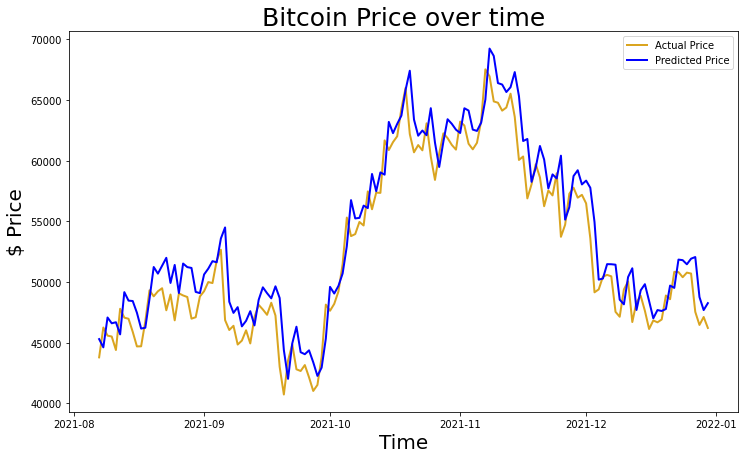

In [13]:
plt.figure(figsize = (12, 7))
plt.plot(y_result["datetime"], y_result["close_bitcoin_true"], color='goldenrod', lw=2)
plt.plot(y_result["datetime"], y_result["close_bitcoin_pred"], color='blue', lw=2)
plt.title("Bitcoin Price over time", size=25)
plt.xlabel("Time", size=20)
plt.ylabel("$ Price", size=20)
plt.legend(['Actual Price', 'Predicted Price'])
plt.show()